# IPA to IMAGE model

## Prerequisites

In principle, this should work on a computer without a GPU. It will help if you have a lot of RAM.

- Pull latest changes from https://github.com/gchrupala/reimaginet
- Download http://grzegorz.chrupala.me/data/coco.zip and unzip it in the `reimaginet/data/coco directory`.
  You should have the following files:
  
  - `dataset.json` - MSCOCO sentences
  - `vgg_feats.mat` - MSCOCO image vectors
  - `dataset.ipa.jsonl.gz`  - IPA transcriptions of MSCOCO sentences

- Download http://grzegorz.chrupala.me/data/model-ipa.zip and put it in the examples directory (same as this notebook)

In [1]:
import imaginet.task

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: Tesla K20m


## Load the model

(It will take a couple of minutes)

In [2]:
model = imaginet.task.load(path="model-ipa.zip")

## Symbol embeddings

In [3]:
emb = imaginet.task.embeddings(model)
print(emb.shape)

(49, 256)


The table of IPA symbols corresponding to  the 49 dimensions 

In [4]:
symb = imaginet.task.symbols(model)
print " ".join(symb.values())

<BEG> <END> <UNK> t ˈ u ː k æ s l e ɪ ŋ ə ɡ ˌ ɛ ð ɚ ɹ ɑ n p o ʊ z v a ʃ ɐ m ᵻ d i f j b ɔ h w ʒ ʌ ɾ θ ɜ ̃ r ʲ


Let's display the embeddings projected to 2D via PCA

In [5]:
%pylab inline
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
xy = pca.fit_transform(emb)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/matplotlib-1.4.3-py2.7-linux-x86_64.egg/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


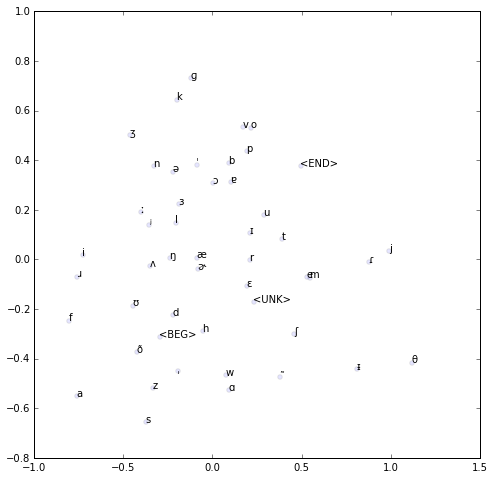

In [6]:
pylab.rc('font', family='DejaVu Sans')
pylab.figure(figsize=(8,8))
pylab.scatter(xy[:,0], xy[:,1], alpha=0.1)
for j,symb_j in symb.items():
    pylab.text(xy[j,0], xy[j,1], symb_j)

Seems mostly random...

## Load MSCOCO validation data

In [7]:
from imaginet.data_provider import getDataProvider
# Adjust the root to point to the directory above data
prov = getDataProvider('coco', root="..")

In [8]:
sents = list(prov.iterSentences(split='val'))

In [9]:
from imaginet.simple_data import phonemes
sents_ipa = [ phonemes(sent) for sent in sents ]

## Project sentences to state space

In [10]:
reps = imaginet.task.representation(model, sents_ipa)

## Find similar sentences in state space

Compute the pairwise cosine distance matrix.

In [11]:
from scipy.spatial.distance import cdist
distance = cdist(reps, reps, metric='cosine')

### Display neighbors for a sentence

In [32]:
import numpy
def neighbors(k, distance=distance):
    nn =  numpy.argsort(distance[k,:])[1:5]
    print sents[k]['raw'], ''.join(sents_ipa[k])
    for n in nn:
        print u"✔" if sents[n]['imgid']==sents[k]['imgid'] else u"✘", \
        sents[n]['raw'], ''.join(sents_ipa[n])

In [33]:
import random

In [34]:
for _ in range(10):
    neighbors(random.randint(0, len(sents)))
    print

A young elephant holds its trunk up to its mouth. ɐjˈʌŋˈɛlɪfənthˈoʊldzɪtstɹˈʌŋkˌʌptʊɪtsmˈaʊθ
✘ A couple of elephants touch their trunks together. ɐkˈʌpəlʌvˈɛlɪfəntstˈʌtʃðɛɹtɹˈʌŋkstəɡˈɛðɚ
✘ A large  elephant feeding itself using its trunk  ɐlˈɑːɹdʒˈɛlɪfəntfˈiːdɪŋɪtsˈɛlfjˈuːzɪŋɪtstɹˈʌŋk
✘ An adult elephant holding some grass with baby elephants nearby. ɐnɐdˈʌltˈɛlɪfənthˈoʊldɪŋsˌʌmɡɹˈæswɪðbˈeɪbiˈɛlɪfəntsnɪɹbˈaɪ
✘ Elephants with long tusks greeting each other with their trunks ˈɛlɪfəntswɪðlˈɑːŋtˈʌsksɡɹˈiːɾɪŋˈiːtʃˈʌðɚwɪððɛɹtɹˈʌŋks

a man riding a dirtbike on the beach ɐmˈænɹˈaɪdɪŋɐdˈɜːtbaɪkɑːnðəbˈiːtʃ
✔ A man riding a dirt bike on top of a sandy beach. ɐmˈænɹˈaɪdɪŋɐdˈɜːtbˈaɪkˌɑːntˈɑːpəvəsˈændibˈiːtʃ
✔ a man riding a dirt bike in the sand ɐmˈænɹˈaɪdɪŋɐdˈɜːtbˈaɪkɪnðəsˈænd
✘ A man riding a dirt bike through a desert field. ɐmˈænɹˈaɪdɪŋɐdˈɜːtbˈaɪkθɹuːɐdˈɛsɚtfˈiːld
✔ The dirt bike throws up sand while riding on a beach. ðədˈɜːtbˈaɪkθɹˈoʊzˌʌpsˈændwˌaɪlɹˈaɪdɪŋˌɑːnɐbˈiːtʃ

A modern crisp motel room